### Modeling notebook
This notebook contains models that is used to train our data and evaluation.

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

In [8]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_valid = np.load("X_valid.npy")
y_valid = np.load("y_valid.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

E0000 00:00:1752955674.546083   10889 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752955674.546751   10889 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-07-19 23:37:54.548409: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.
2025-07-19 23:37:55.042484: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2025-07-19 23:37:55.161077: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] A

In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,
    layers.Conv2D(32, activation="relu", kernel_size=3, kernel_initializer="he_normal", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),
    
    layers.Conv2D(64, activation="relu", kernel_size=3, kernel_initializer="he_normal", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    layers.Conv2D(128, activation="relu", kernel_size=3, kernel_initializer="he_normal", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(rate=0.1),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [6]:
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[lr_schedule, early_stop],
    epochs=25
)

Epoch 1/25


2025-07-19 23:48:20.488287: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


   3/1407 ━━━━━━━━━━━━━━━━━━━━ 1:37 70ms/step - accuracy: 0.0990 - loss: 2.7821

2025-07-19 23:48:23.495026: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21528576 exceeds 10% of free system memory.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - accuracy: 0.3785 - loss: 1.7093 - val_accuracy: 0.5162 - val_loss: 1.3082 - learning_rate: 0.0010
Epoch 2/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.5286 - loss: 1.3131 - val_accuracy: 0.5668 - val_loss: 1.1901 - learning_rate: 0.0010
Epoch 3/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.5783 - loss: 1.1758 - val_accuracy: 0.5982 - val_loss: 1.1968 - learning_rate: 0.0010
Epoch 4/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.6121 - loss: 1.0918 - val_accuracy: 0.6486 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 5/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.6359 - loss: 1.0328 - val_accuracy: 0.6670 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 6/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.6522 - loss: 0.9823 - val_accuracy: 0.6568 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 7/25
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - accuracy: 0.6672 

In [8]:
# changed the optimizer from Nadam to SGD and recompiled it.
new_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(
    optimizer=new_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    initial_epoch=25,
    callbacks=[lr_schedule, early_stop]
)

Epoch 26/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - accuracy: 0.7609 - loss: 0.6891 - val_accuracy: 0.7684 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 27/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 78s 56ms/step - accuracy: 0.7558 - loss: 0.6928 - val_accuracy: 0.7650 - val_loss: 0.6656 - learning_rate: 0.0010
Epoch 28/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.7636 - loss: 0.6739 - val_accuracy: 0.7658 - val_loss: 0.6670 - learning_rate: 0.0010
Epoch 29/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.7646 - loss: 0.6731 - val_accuracy: 0.7742 - val_loss: 0.6575 - learning_rate: 0.0010
Epoch 30/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.7660 - loss: 0.6702 - val_accuracy: 0.7696 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 31/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.7656 - loss: 0.6697 - val_accuracy: 0.7626 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 32/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step -

In [11]:
import pickle


model.save("simple_CNN_model_v1.keras")

with open("history_nadam.pkl", "wb") as f:
    pickle.dump(history.history, f)

with open("history_sgd.pkl", "wb") as f:
    pickle.dump(history2.history, f)

In [3]:
import pickle

with open("history_nadam.pkl", "rb") as f:
    history1 = pickle.load(f)

with open("history_sgd.pkl", "rb") as f:
    history2 = pickle.load(f)

In [4]:
def merge_histories(hist1, hist2):
    merged = {
        "accuracy": hist1["accuracy"] + hist2["accuracy"],
        "val_accuracy": hist1["val_accuracy"] + hist2["val_accuracy"],
        "loss": hist1["loss"] + hist2["loss"],
        "val_loss": hist1["val_loss"] + hist2["val_loss"]
    }
    return merged

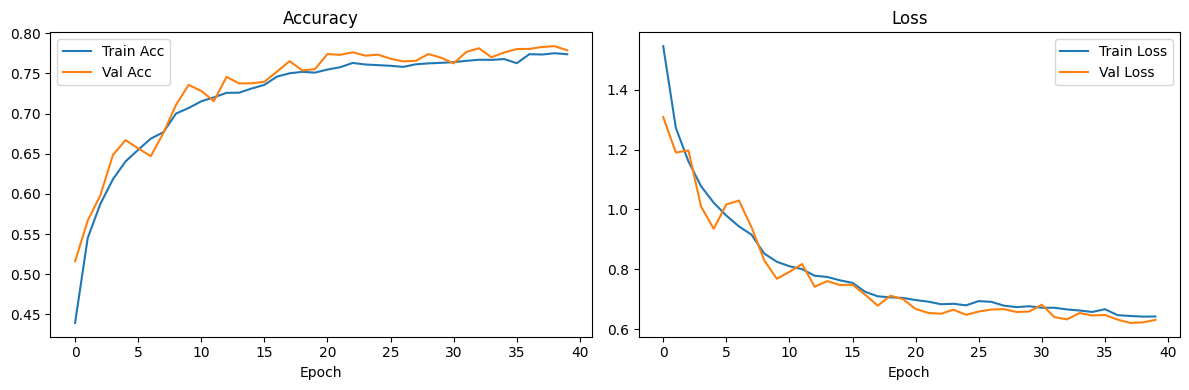

In [7]:
merged_history = merge_histories(history1, history2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(merged_history["accuracy"], label="Train Acc")
plt.plot(merged_history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(merged_history["loss"], label="Train Loss")
plt.plot(merged_history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model = models.load_model("simple_CNN_model_v1.keras")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

2025-07-25 00:18:18.603389: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7748 - loss: 0.6499
Test Accuracy: 0.7726, Test Loss: 0.6613


 22/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

2025-07-25 00:31:17.898646: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


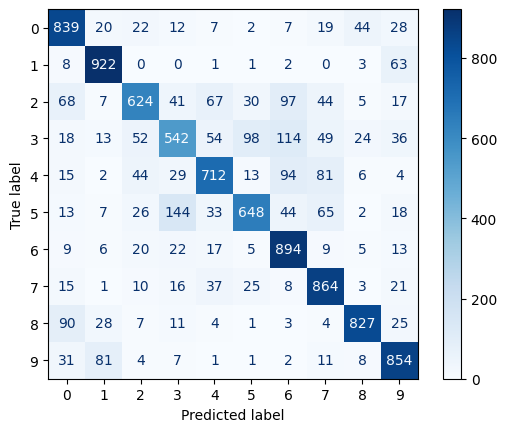

In [16]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

In [18]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7586    0.8390    0.7968      1000
           1     0.8482    0.9220    0.8836      1000
           2     0.7713    0.6240    0.6899      1000
           3     0.6578    0.5420    0.5943      1000
           4     0.7631    0.7120    0.7367      1000
           5     0.7864    0.6480    0.7105      1000
           6     0.7067    0.8940    0.7894      1000
           7     0.7539    0.8640    0.8052      1000
           8     0.8921    0.8270    0.8583      1000
           9     0.7915    0.8540    0.8215      1000

    accuracy                         0.7726     10000
   macro avg     0.7730    0.7726    0.7686     10000
weighted avg     0.7730    0.7726    0.7686     10000



/tmp/ipykernel_3461/711116161.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = class_names[int(y_true[idx])]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7825811093352841..1.374956411464504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9729853819463266..1.8355837231989007].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4313784267639886..2.0572383883207395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.318724559523889..2.0096373201679794].
Clipping input data to the valid range for imsho

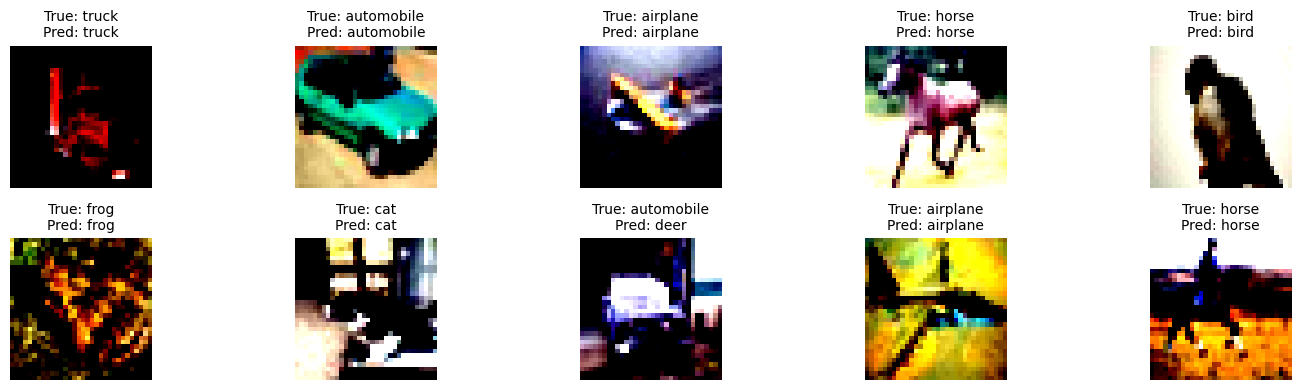

In [23]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

indices = random.sample(range(len(X_test)), 10)
plt.figure(figsize=(15, 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = class_names[int(y_true[idx])]
    pred_label = class_names[int(y_pred[idx])]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
